# Calculate doublet scores for each cell using Scrublet

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.19 GB, difference +0.19 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## Import scrublet: the doublet detector

In [5]:
import scrublet as scr

# Load data

In [6]:
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

# overwrite obs with the most recent version
adata.obs = rz.load_df('backups/obs_info_27563x10_200517_12h03.npz')
print(adata.shape)
adata.obs.head()

(27563, 40930)


,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo


## Load details on the latest SPRING plot  
In general, this is not necessary to run Scrublet. However, I want to use the same principal component space for both my SPRING plot and Scrublet. Thanks to Sam Wolock for guidance for how to do it. 

In [7]:
# load intermediates I saved when preparing the SPRING plot
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri/'
plot_name = 'all_cells_w_dblt_1000umi'


params = rz.load_stuff(project_dir+plot_name+'/params.pickle')
params.keys()

dict_keys(['k', 'cell_mask', 'min_counts', 'min_cells', 'base_ix', 'num_pc', 'plot_name', 'gene_names_excluded', 'abundant_gene_mask', 'v_score_dict', 'genes_used', 'eigenvectors', 'eigenvalues'])

In [8]:
# make sure the data is unnormalized, should sum to different total counts (and round numbers)
adata.X[:5,:].sum(axis=1)

matrix([[14875.],
        [ 6876.],
        [ 4643.],
        [ 5972.],
        [ 5021.]], dtype=float32)

In [9]:
# prepare  variables to plug into scrublet
gene_mask = np.in1d(adata.var_names,params['genes_used'])
cell_mask = params['cell_mask'].astype(bool)
n_counts = np.array(adata[cell_mask,:].X.sum(axis=1).T)[0]
P = params['eigenvectors'][:params['num_pc'],:] #eigenvector
print(gene_mask.sum(),len(gene_mask))
print(cell_mask.sum(),len(cell_mask))
postnorm_total = 1e4

X = adata[cell_mask].X
X_norm = sc.pp.normalize_per_cell(adata[cell_mask],counts_per_cell_after=postnorm_total,copy=True).X
subobs = adata.obs[cell_mask]

4001 40930
26009 27563
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [10]:
gene_means = X_norm[:,gene_mask].mean(0).A.squeeze()
gene_stdevs = np.sqrt(scr.sparse_var(X_norm[:, gene_mask]))

In [11]:
# double-check the shapes
print(P.shape,len(gene_means))

(185, 4001) 4001


## Calculate doublet scores

### Decide on which cells to treat collectively

In [16]:
# doublet can only be made of real cells present in the same cell suspension being injected into
# a scRNAseq device.
# therefore, it makes sense to run the doublet detector on each separate cell suspension (in other words,
# for each emulsion)
# also, the doublet rate can be different between samples.
# what is the adata.obs column with emulsion information called?
splitby = 'mouse'
subobs[splitby].unique()

array(['CSF1Ri_1', 'CSF1Ri_2', 'Vehicle_1', 'Vehicle_2', 'Healthy_1',
       'Healthy_2'], dtype=object)

In [17]:
subobs.groupby([splitby,'library']).count().dropna().iloc[:,:1]

barcode
mouse     library             
CSF1Ri_1  CSF1Ri_1_1      1415
          CSF1Ri_1_2       886
          CSF1Ri_1_3       816
CSF1Ri_2  CSF1Ri_2_1      2211
          CSF1Ri_2_2      2527
          CSF1Ri_2_3      2485
Healthy_1 Healthy_1_1     1720
          Healthy_1_2     1308
Healthy_2 Healthy_2_1     1378
          Healthy_2_2      721
          Healthy_2_3     1326
Vehicle_1 Vehicle_1_1      947
          Vehicle_1_2     2180
          Vehicle_1_3     2465
Vehicle_2 Vehicle_2_1     1686
          Vehicle_2_2     1938

### Run Scrubet on each emulsion separately  
By design, doublets cannot form between emulsions  

In [18]:
# I want to apply the same principal component transformation to all emulsions but allow
# simulated doublets only within the same emulsion

# This is 

scrub_dict = {}
doub_score_dict = {}
predict_doub_dict = {}

for emulsion in adata.obs[cell_mask][splitby].unique():
    cmask = (adata.obs[cell_mask][splitby] == emulsion).values
    
    # select the expression data:
    E = X[cmask,:][:,gene_mask]
    
    # initiate the scrub object
    scrub = scr.Scrublet(E, total_counts=n_counts[cmask], expected_doublet_rate=0.06)
     
    # Simulate doublets
    scrub.simulate_doublets()
    
    # Total counts normalize
    scrub._E_obs_norm = scr.tot_counts_norm(scrub._E_obs, total_counts=n_counts[cmask], target_total=postnorm_total)
    scrub._E_sim_norm = scr.tot_counts_norm(scrub._E_sim, total_counts=scrub._total_counts_sim, target_total=postnorm_total)
    
    # Z-score using previously calculated gene means and standard deviations. Same way as for original spring plot.
    scrub._E_obs_norm = np.array(scr.sparse_zscore(scrub._E_obs_norm, gene_means, gene_stdevs))
    scrub._E_sim_norm = np.array(scr.sparse_zscore(scrub._E_sim_norm, gene_means, gene_stdevs))
    
    # Transform simulated doublets into same PCA space as the observed cells
    pca_obs = P.dot(scrub._E_obs_norm.T).T
    pca_sim = P.dot(scrub._E_sim_norm.T).T
    
    # Set the "manifold", i.e. the space in which the knn graph will be constructed
    scrub.set_manifold(pca_obs, pca_sim)
    
    # Calculate doublet scores and call doublets as usual
    doublet_scores = scrub.calculate_doublet_scores()
    predicted_doublets = scrub.call_doublets()
    
    # store results
    scrub_dict[emulsion] = scrub
    doub_score_dict[emulsion] = doublet_scores
    predict_doub_dict[emulsion] = predicted_doublets

Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.3%
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.9%
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.8%
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 6.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 12.3%
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 7.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.5%
Automatically set threshold at doublet score = 0.41
Detected doublet

## Check doublet histograms

In [19]:
# print the automatically determined threshold:
for key,value in scrub_dict.items():
    print(key,value.threshold_)

CSF1Ri_1 0.5280312636188553
CSF1Ri_2 0.6371549184559784
Vehicle_1 0.5955167071069174
Vehicle_2 0.5474833423497025
Healthy_1 0.5331606309677914
Healthy_2 0.40807999649419735


CSF1Ri_1 3228
predicted doublet percentage 0.7378889958293231


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


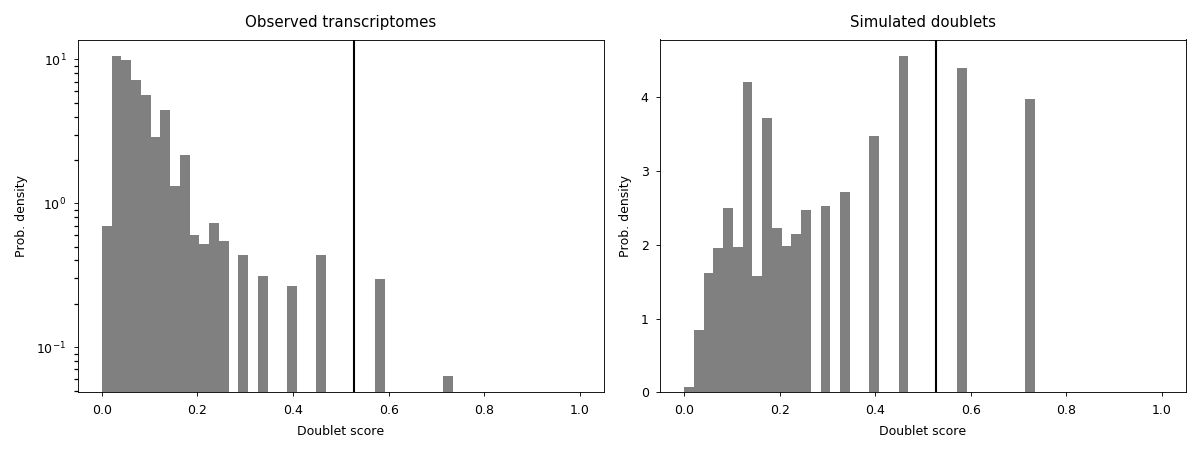


CSF1Ri_2 7652
predicted doublet percentage 0.20766994323688218


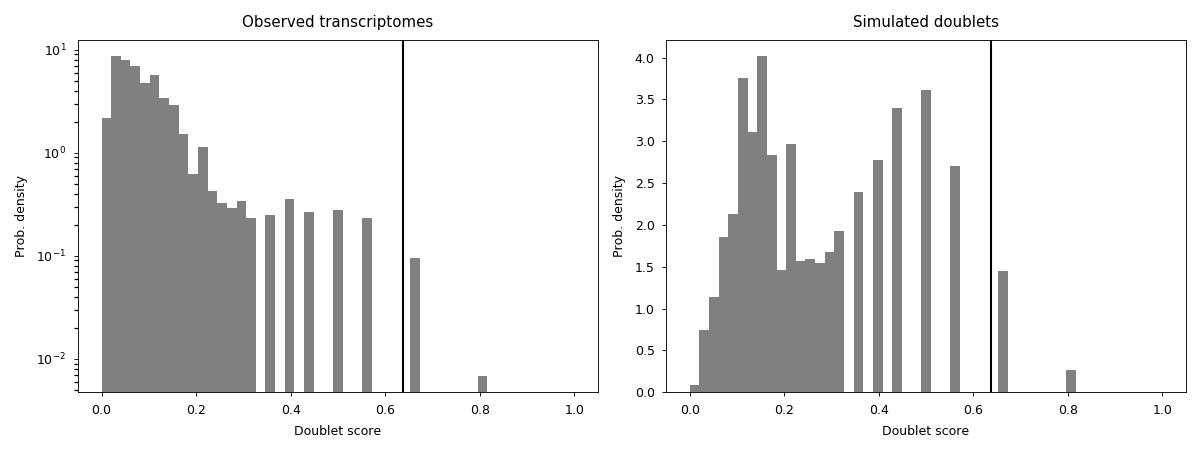


Vehicle_1 5820
predicted doublet percentage 0.17882689556509299


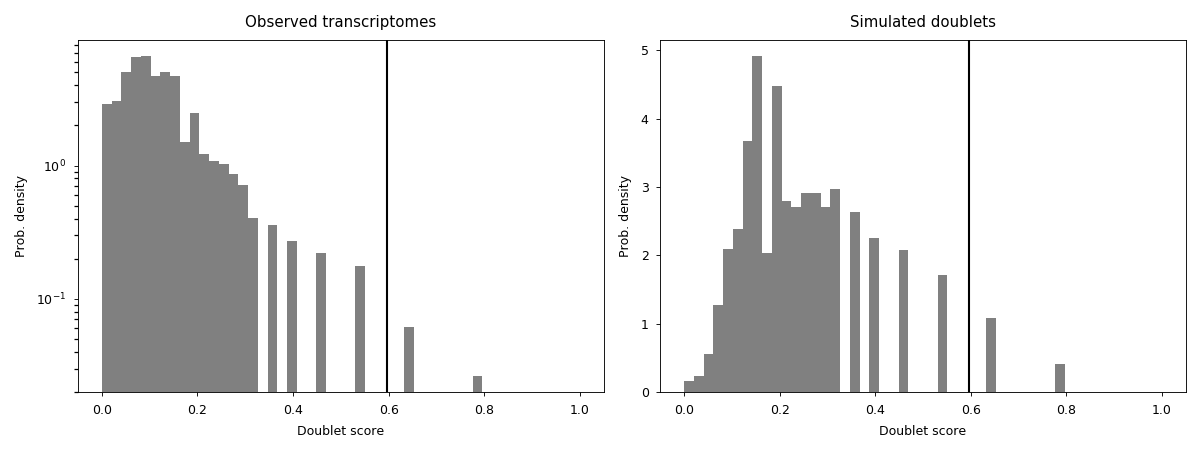


Vehicle_2 3853
predicted doublet percentage 0.7450331125827815


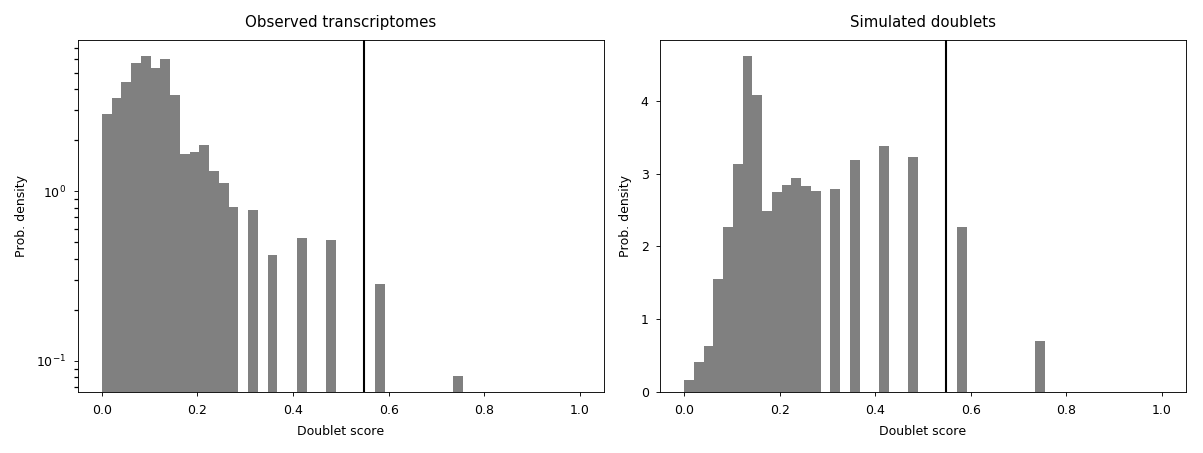


Healthy_1 3320
predicted doublet percentage 0.5284015852047557


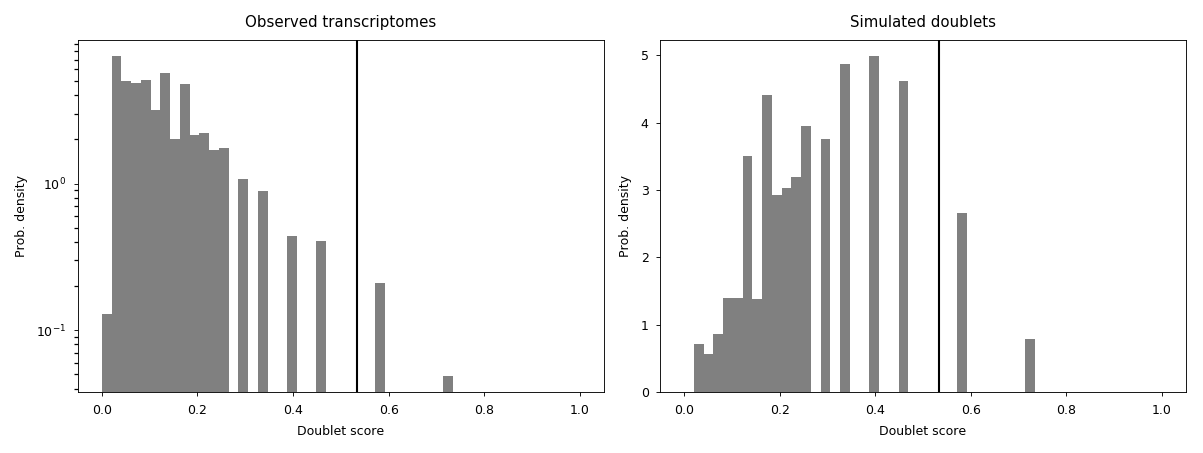


Healthy_2 3690
predicted doublet percentage 1.5474452554744527


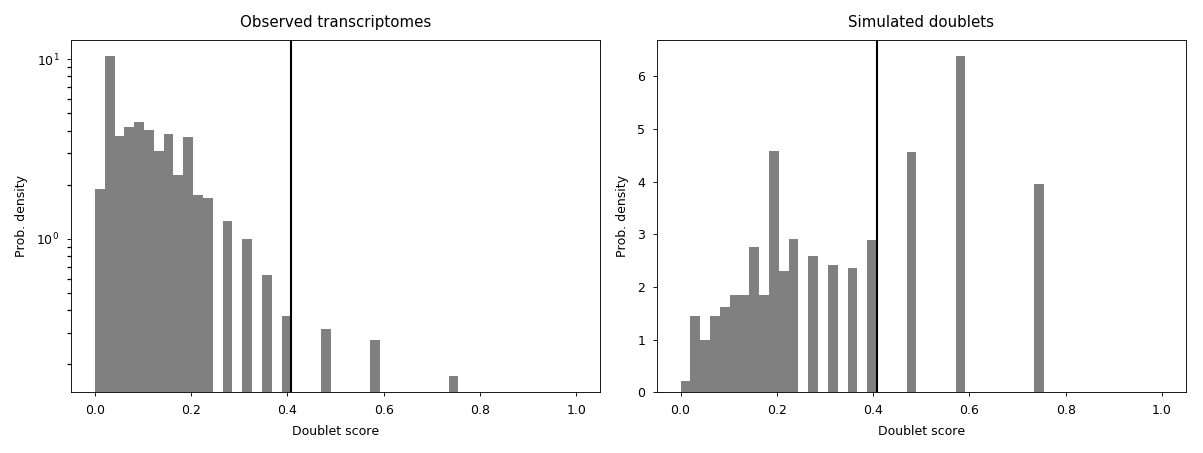

In [20]:
for emulsion, scrub in scrub_dict.items():
    print(emulsion,(adata.obs[splitby] == emulsion).sum())
    dmask = predict_doub_dict[emulsion]
    print('predicted doublet percentage',dmask.sum()/len(dmask)*100.)
    scrub.plot_histogram();
    plt.show()
    print()

## Add results to adata.obs

In [21]:
obs = adata.obs.copy()

# add the results to obs
obs['doublet_score'] = np.nan
obs['potential_doublet'] = np.nan

for key,value in doub_score_dict.items():
    cmask = (obs[splitby] == key).values
    
    obs.loc[cmask&cell_mask,'doublet_score'] = value
    obs.loc[cmask&cell_mask,'potential_doublet'] = predict_doub_dict[key]
    
    # also add another colortrack: within the x% with highest doublet score
    for i in [3,5,10]:   
        obs.loc[cmask&cell_mask,'top%dpct_dbtl_score'%i] = \
        obs.loc[cmask&cell_mask,'doublet_score']>=obs.loc[cmask,'doublet_score'].quantile(1.-float(i)/100.)

## Save obs only

In [22]:
# save the update obs dataframe
# no need to save the entire adata object, counts didn't change

fname = 'backups/obs_info_%dx%d_%s'%(obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups/obs_info_27563x15_200524_12h47


## Optional: add colotrack to SPRING

In [23]:
adata.obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo


In [24]:
# path
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri/'
plot_name = 'all_cells_w_dblt_1000umi'

# select to append:
toappend = ['potential_doublet',
            'top3pct_dbtl_score','top5pct_dbtl_score','top10pct_dbtl_score']

toappend_cont = ['doublet_score']

# color dictionary
cdd = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')
cdd = {key:value['label_colors'] for key,value in cdd.items()}

# get cell filter:
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

# prepare cell groupings dictionary (discrete)
cg = obs.iloc[cell_ix][toappend].astype(str).to_dict(orient='list')

# prepare numerical
ctracks = obs[cell_mask][toappend_cont].fillna(0).astype(float).to_dict(orient='list')

# append categorical
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)
# append numerical
srz.append_color_tracks(ctracks,project_dir+plot_name,backup=True)